## _Dataset Description:_ ##

Our chosen dataset is the **Medical Cost Personal Datasets**. There are 6 features (age, sex, bmi, children, smoker, and region), and 1 label to be predicted which is the charges, with 1137 rows of data. Insights on the columns are gone into further detail in Step 1: Data Exploration. Since the label (charges) is a numerical, continuous value, this is a regression task. To predict charges, we will use an Artificial Neural Network.

## _Step 1: Data Exploration_ ##

In [2]:
# Read the file
import pandas as pd
data = pd.read_csv('insurance_dataset.csv')

In [3]:
# Use .head() to understand the data structure through the first 5 rows
data.head()

,age,sex,bmi,children,smoker,region,charges
0,52,male,27.360,0,yes,northwest,24393.62240
1,30,male,44.220,2,no,southeast,4266.16580
2,19,male,27.265,2,no,northwest,22493.65964
3,20,female,26.840,1,yes,southeast,17085.26760
4,27,female,24.750,0,yes,southeast,16577.77950


In [4]:
# Use .info() to learn more the data types and instances of non-null data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1137 non-null   int64  
 1   sex       1137 non-null   object 
 2   bmi       1137 non-null   float64
 3   children  1137 non-null   int64  
 4   smoker    1137 non-null   object 
 5   region    1080 non-null   object 
 6   charges   1137 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 62.3+ KB


**From the data types, we see that there are 3 columns with non-numerical data: 'sex', 'smoker', and 'region' - the rest are integers or float (numerical).** 

In [5]:
# To check the different categories in each:
data['sex'].value_counts()

sex
male       559
female     523
wqeqwrf     35
dasdas      20
Name: count, dtype: int64

***'wqeqwrf' and 'dasdas' are nonsensical typos and will need to be cleaned later on***

In [6]:
data['smoker'].value_counts()

smoker
no     905
yes    232
Name: count, dtype: int64

In [7]:
data['region'].value_counts()

region
southeast    296
northwest    264
southwest    264
northeast    256
Name: count, dtype: int64

**From the count of non-null data/entries, we see that the 'region' column has less non-null data, so it has missing data.**

In [8]:
# To check how much 'region' is missing using a code: 

total_rows_count = len(data.index)  # the total number of rows in the dataset

total_non_null_cells = data['region'].count()  # the total non-empty cells of the 'region' column

null_cells_count = total_rows_count - total_non_null_cells  # finding the total empty/missing cells

print(f"There are {null_cells_count} empty cells in 'region' column.")

There are 57 empty cells in 'region' column.


In [9]:
# Use .describe() to get a some statistical insights into the dataset
data.describe()

,age,bmi,children,charges
count,1137.000000,1137.000000,1137.000000,1137.000000
mean,35.681618,30.550752,0.985928,13285.245207
std,21.581298,6.124758,1.305384,12068.858512
min,-63.000000,15.960000,-5.000000,1121.873900
25%,25.000000,26.180000,0.000000,4779.602300
50%,38.000000,30.210000,1.000000,9504.310300
75%,51.000000,34.485000,2.000000,16586.497710
max,64.000000,53.130000,5.000000,63770.428010


## _Step 2: Data Visualisation_ ##

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

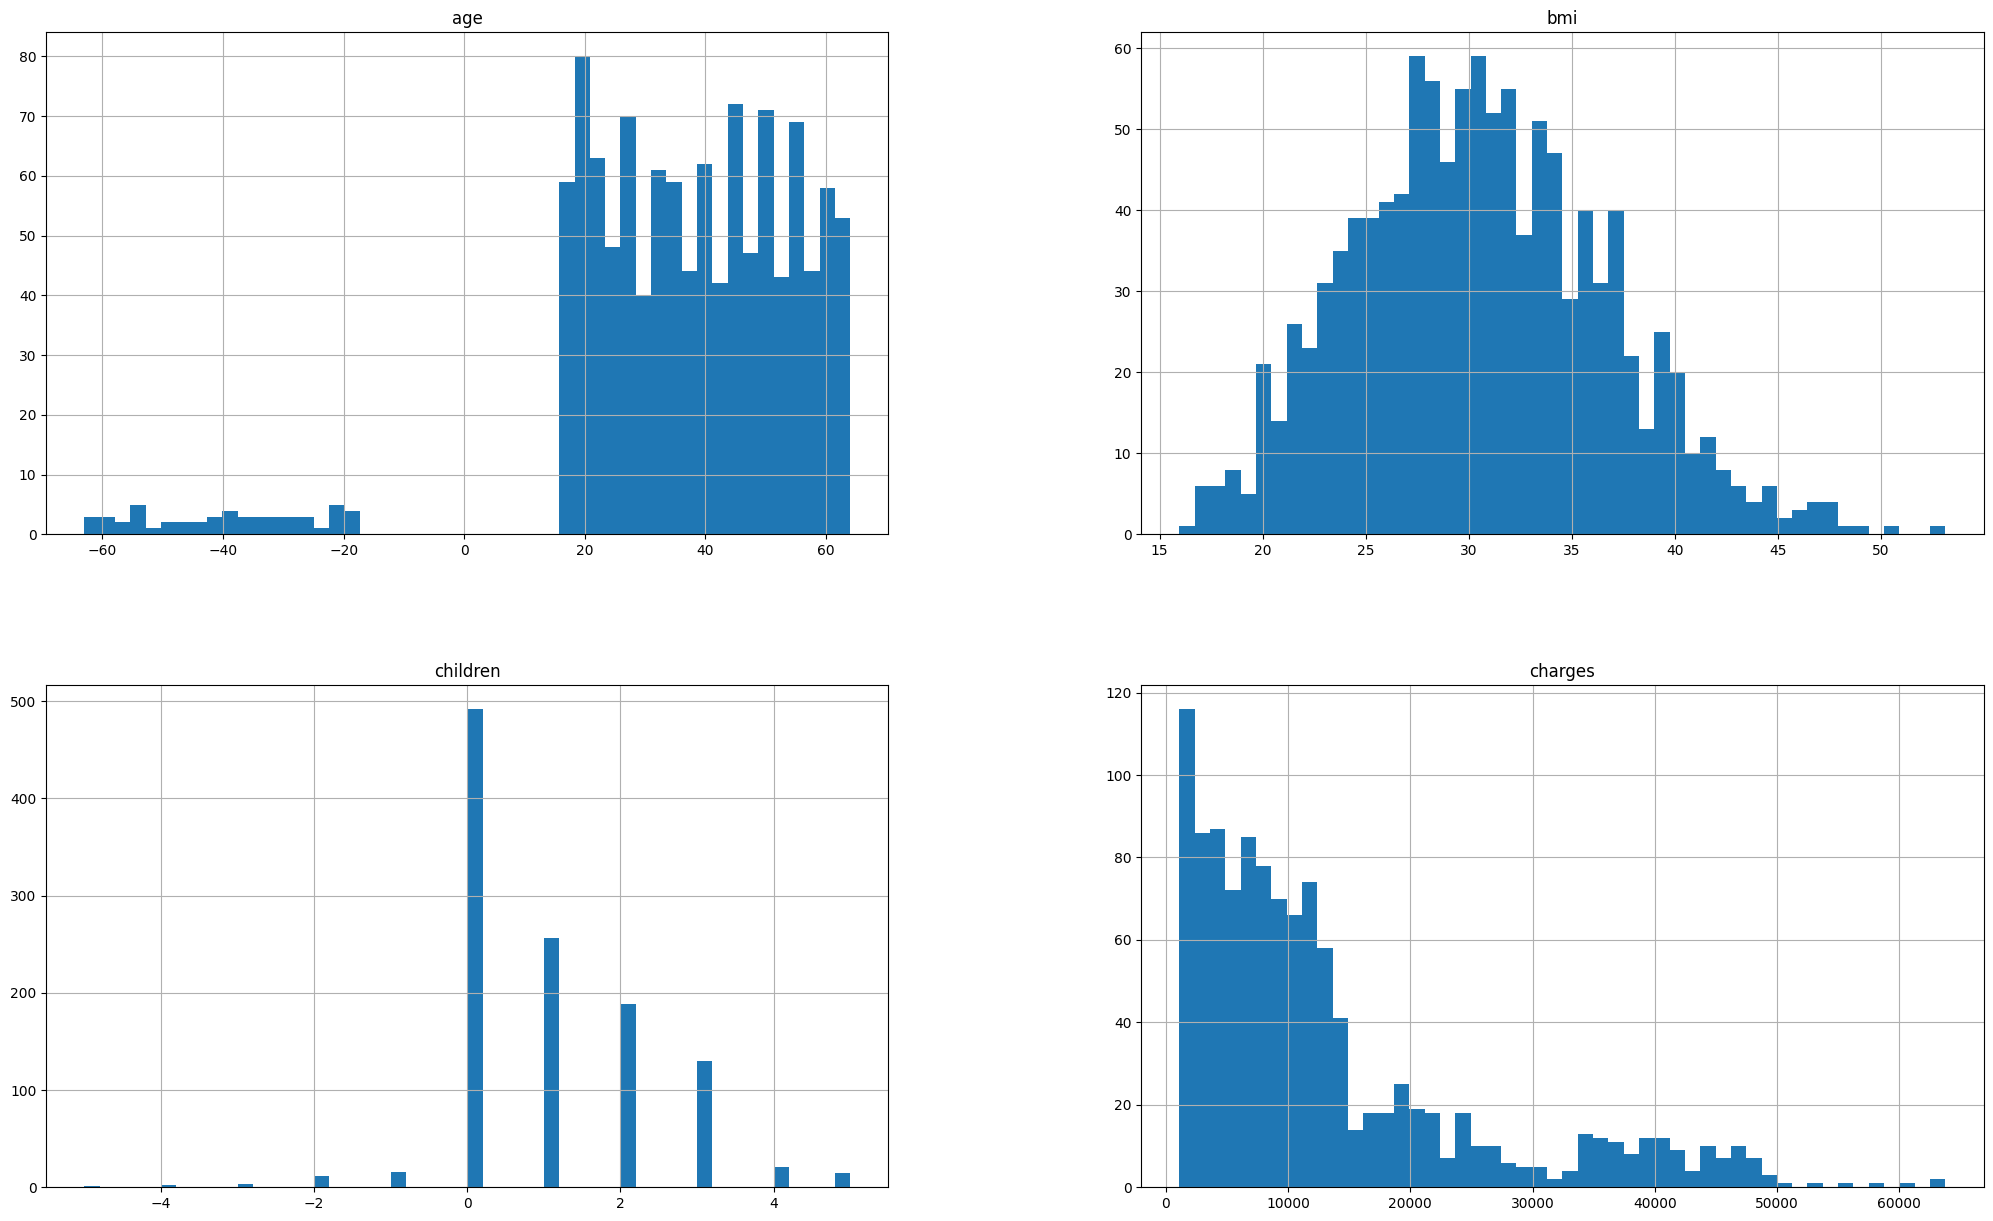

In [10]:
# Visualise the numerical columns' distributions using histograms
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(25,15))

**From the histograms, there seem to be anamolies in some columns. For example, 'age' and 'children' have negative values which does not make sense.**

<Axes: title={'center': 'charges and children'}, xlabel='children', ylabel='charges'>

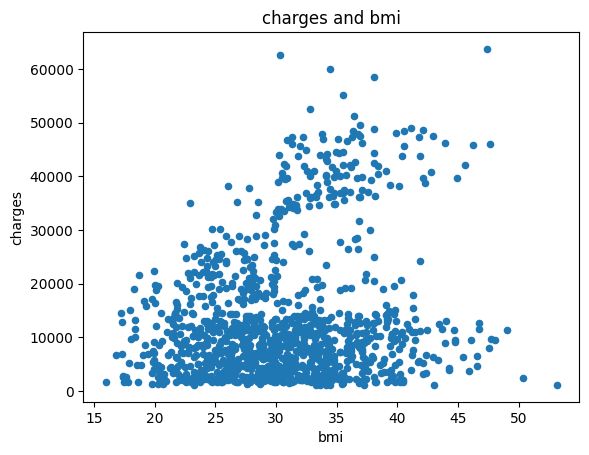

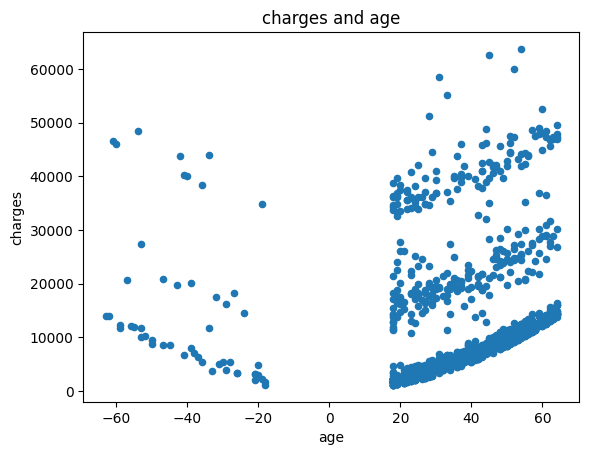

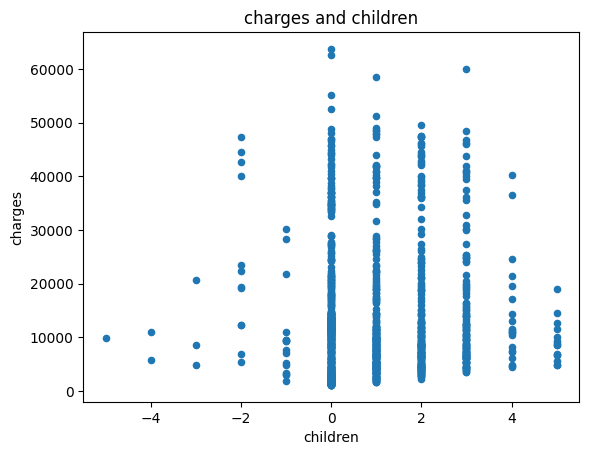

In [9]:
# To visualise the general relationship between charges, bmi and age
data.plot(kind='scatter', x='bmi', y='charges', title='charges and bmi')
data.plot(kind='scatter', x='age', y='charges', title='charges and age')
data.plot(kind='scatter', x='children', y='charges', title='charges and children')


In [12]:
# For the correlation matrix, we first drop the 3 non-numerical columns
data_no_categorical = data.drop("region", axis='columns')
data_no_categorical = data_no_categorical.drop("sex", axis='columns')
data_no_categorical = data_no_categorical.drop("smoker", axis='columns')

# Correlation matrix
corr_matrix=data_no_categorical.corr()
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
bmi         0.200124
age         0.132962
children    0.047785
Name: charges, dtype: float64

**From the scatter plots, we can't see a direct/linear relationship for bmi with the charges, while age looks proportional to charge; when the age increases in magnitude (even for the negatives, suggesting the magnitudes of these values are correct), so do the charges.** 
**The correlations however show that bmi is the highest correlated with charges followed by age (although they're both relatively low), while children is much less correlateed with charges.**
**For the children, the negatives don't show as clear as a relationship with the positives, unlike age.**

<Axes: title={'center': 'charges'}, xlabel='smoker'>

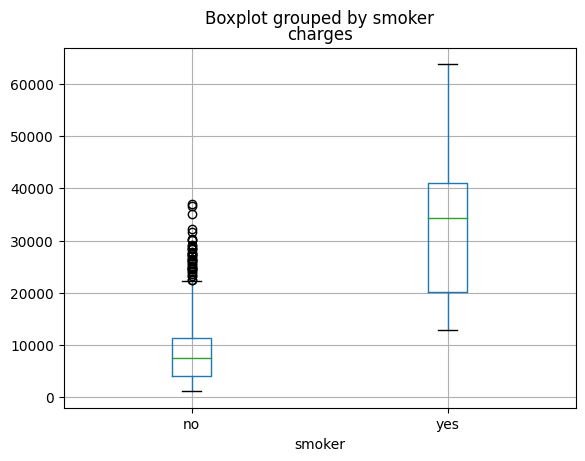

In [13]:
data.boxplot(column='charges', by='smoker')

<Axes: title={'center': 'charges'}, xlabel='region'>

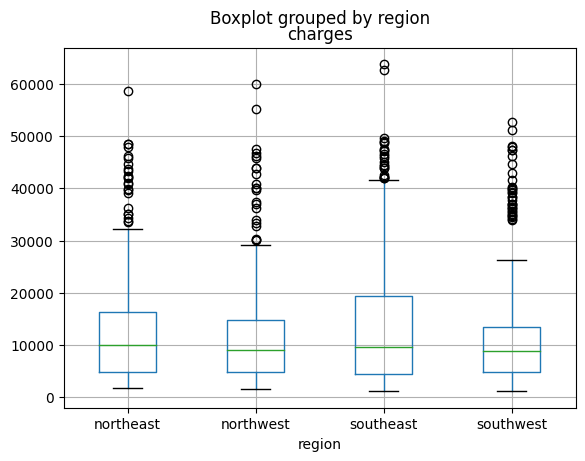

In [14]:
data.boxplot(column='charges', by='region')

**The smoker box plot shows a significant relationship between smoking and charges, where the median charges are much higher for those who smoke. The outliers for those who don't smoke suggests other factors can cause higher charges.
As for the region box plot, the distributions are relatively the same, so region may not have that much of a significant relationship with charges.**

**We will return to do one more visualisation (correlation & its heatmap) and analyse what it means after preprocessing the data (as it must all be numerical).**

## _Step 3: Data Preprocessing_ ##

**Since any new data should pass through the same preprocessing we have done on the training dataset, we will define two functions to do all the preprocessing for the training and testing data. In them, we do general preprocessing like scaling and one hot encoding, but we also did come cleaning specific to the outliers/issues in our datasets. For example, mode imputing the two repeated typos in 'sex', and mode imputing the missing values in 'region'. Also, from our previous observations in the age-charges scatter graph, the negative ages seem to be an error in sign, but with correct magnitudes. Therefore we can take their absolute values. Since we couldn't conclude the same for the children, we'll impute the negative outliers by the mode.**

**Note:** We will split the data into 2 groups (train and test) instead of 3 (train, validation, and test) because:
1.  We are treating the unseen dataset as the final "test" set, so the train and test we define below will serve the purposes of train and validation sets respectively. With that considered, it is the same as if were to have a large dataset split into 3.
2.  Our dataset is quite small.


So, for the course of this project the 'test' set is used to validate the model and tune the hyperparameters.

In [3]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_set, test_set = train_test_split(data, test_size=0.2, random_state=5, shuffle=True)

# Split features and target
X_train = train_set.drop("charges", axis=1)
y_train = train_set["charges"]
X_test = test_set.drop("charges", axis=1)
y_test = test_set["charges"]

# Function to preprocess training data
def preprocessing_training(training_data):
    import numpy as np
    # Separate numerical and categorical columns
    numerical_cols = training_data.select_dtypes(include=["float64", "int64"]).columns
    categorical_cols = training_data.select_dtypes(include=["object"]).columns

    ################################# Handling 'age' & 'children' Outliers ########################################
    
    training_data['age'] = training_data['age'].abs()
    # replace all negative values in children by np.nan (instead of None to keep it numerical)
    training_data.loc[training_data['children'] < 0, 'children'] = np.nan
    # next we can impute the np.nan with the mode number of children
    imp_neg_mode = SimpleImputer(missing_values = np.nan, strategy='most_frequent') 
    training_data[['children']] = imp_neg_mode.fit_transform(training_data[['children']])

    ################################# Mode-Imputing 'region' Missing Values #######################################
    
    import numpy as np
    
    imp_region_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
    X_train[['region']] = imp_region_mode.fit_transform(X_train[['region']])

    ###################################### Mode-Imputing 'sex' Typos ##############################################

    # first we replace instances of the two typos with None
    X_train.loc[X_train['sex'] == 'dasdas', 'sex'] = None
    X_train.loc[X_train['sex'] == 'wqeqwrf', 'sex'] = None
    
    # next we can impute the None with the mode 
    imp_typos_mode = SimpleImputer(missing_values=None, strategy='most_frequent') 
    X_train[['sex']] = imp_typos_mode.fit_transform(X_train[['sex']])

    ################################## Median-Imputing Numerical Missing Values ####################################
    
    # While we don't have any in our dataset, we might in the unseen set.
    # Impute missing values for numerical data
    imputer = SimpleImputer(strategy="median")
    training_data[numerical_cols] = imputer.fit_transform(training_data[numerical_cols])
    
    ############################################## Feature Scaling ################################################
    
    # Scale numerical features
    scaler = MinMaxScaler()
    training_data[numerical_cols] = scaler.fit_transform(training_data[numerical_cols])
    
    ############################################ Categorization ###################################################
    
    # One-hot encode categorical features
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded_categorical = one_hot_encoder.fit_transform(training_data[categorical_cols])
    encoded_df = pd.DataFrame(
        encoded_categorical, 
        columns=one_hot_encoder.get_feature_names_out(categorical_cols),
        index=training_data.index
    )
    
    # Combine original data with encoded data
    df_encoded = pd.concat([training_data.drop(columns=categorical_cols), encoded_df], axis=1)
    return df_encoded, imputer, scaler, one_hot_encoder, imp_neg_mode, imp_region_mode, imp_typos_mode
    



# Function to preprocess testing data
def preprocessing_testing(testing_data, imputer, scaler, one_hot_encoder, imp_neg_mode, imp_region_mode, imp_typos_mode):
    import numpy as np

    ################################# Handling 'age' & 'children' Outliers #########################################

    testing_data['age'] = testing_data['age'].abs()
    # replace all negative values in children by np.nan (instead of None to keep it numerical)
    testing_data.loc[X_test['children'] < 0, 'children'] = np.nan
    # next we can impute the np.nan with the mode number of children
    imp_neg_mode = SimpleImputer(missing_values = np.nan, strategy='most_frequent') 
    testing_data[['children']] = imp_neg_mode.fit_transform(testing_data[['children']])

    ################################# Mode-Imputing 'region' Missing Values ##########################################
    
    import numpy as np
    
    imp_region_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
    testing_data[['region']] = imp_region_mode.fit_transform(testing_data[['region']])

    ###################################### Mode-Imputing 'sex' Typos #################################################

    # first we replace instances of the two typos with None
    testing_data.loc[testing_data['sex'] == 'dasdas', 'sex'] = None
    testing_data.loc[testing_data['sex'] == 'wqeqwrf', 'sex'] = None
    
    # next we can impute the None with the mode 
    imp_typos_mode = SimpleImputer(missing_values=None, strategy='most_frequent') 
    testing_data[['sex']] = imp_typos_mode.fit_transform(testing_data[['sex']])

    # Separate numerical and categorical columns
    numerical_cols = testing_data.select_dtypes(include=["float64", "int64"]).columns
    categorical_cols = testing_data.select_dtypes(include=["object"]).columns
    
    ################################## Median-Imputing Numerical Missing Values ####################################
    
    # While we don't have any in our dataset, we might in the unseen set.
    # Impute missing values for numerical data using the imputer from training
    testing_data[numerical_cols] = imputer.transform(testing_data[numerical_cols])
    
    ############################################## Feature Scaling ################################################
    # Scale numerical features using the scaler from training
    testing_data[numerical_cols] = scaler.transform(testing_data[numerical_cols])
    
    ############################################ Categorization ###################################################
    # One-hot encode categorical features using the encoder from training
    encoded_categorical = one_hot_encoder.transform(testing_data[categorical_cols])
    encoded_df = pd.DataFrame(
        encoded_categorical, 
        columns=one_hot_encoder.get_feature_names_out(categorical_cols),
        index=testing_data.index
    )
    
    # Combine original data with encoded data
    df_encoded = pd.concat([testing_data.drop(columns=categorical_cols), encoded_df], axis=1)
    return df_encoded
    

# Preprocessing training data
X_train_transformed, imputer, scaler, one_hot_encoder, imp_neg_mode, imp_region_mode, imp_typos_mode = preprocessing_training(X_train)

# Preprocessing testing data
X_test_transformed = preprocessing_testing(X_test, imputer, scaler, one_hot_encoder, imp_neg_mode, imp_region_mode, imp_typos_mode)


In [4]:
# to examine the data to ensure that region's missing values (as well as other issues we fixed) have been dealt with 
print(X_train_transformed.info())
X_train_transformed

<class 'pandas.core.frame.DataFrame'>
Index: 909 entries, 319 to 867
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               909 non-null    float64
 1   bmi               909 non-null    float64
 2   children          909 non-null    float64
 3   sex_female        909 non-null    float64
 4   sex_male          909 non-null    float64
 5   smoker_no         909 non-null    float64
 6   smoker_yes        909 non-null    float64
 7   region_northeast  909 non-null    float64
 8   region_northwest  909 non-null    float64
 9   region_southeast  909 non-null    float64
 10  region_southwest  909 non-null    float64
dtypes: float64(11)
memory usage: 85.2 KB
None


,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
319,0.021739,0.145539,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
586,0.282609,0.590347,0.4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1048,0.695652,0.314167,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
246,0.086957,0.559660,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
789,0.326087,0.557575,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1032,0.760870,0.359452,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
73,0.086957,0.223000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
998,0.521739,0.275734,0.2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
206,0.630435,0.577238,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [6]:
X_test_transformed

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
613,0.608696,0.090571,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
162,0.478261,0.088932,0.2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
804,0.000000,0.610010,0.2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
258,0.608696,0.701922,0.4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
235,0.434783,0.413377,0.2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1034,0.043478,0.356621,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
923,0.130435,0.196187,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
715,0.304348,0.816475,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
565,0.413043,0.377923,0.4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## _Revisiting Data Visualisation_ ##

**Now that we have preprocessed the data, we can do more visualisations that we were unable to do in _Step 2: Data Visualisation_ due to the categorical and missing data.**

In [24]:
# first we will combine the cleaned X train back with the y train so that we can observe relationships between them.
cleaned_data = X_train_transformed
cleaned_data['charges'] = y_train

In [25]:
# the correlation will give us an idea about which features are more strongly related to the charges
cleaned_data.corr()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges
age,1.000000,0.091309,0.066705,-0.009820,0.009820,0.033262,-0.033262,-0.019768,0.017666,-0.011950,0.015024,0.300422
bmi,0.091309,1.000000,0.017261,-0.039027,0.039027,0.005323,-0.005323,-0.143585,-0.097065,0.237929,-0.019831,0.184161
children,0.066705,0.017261,1.000000,-0.015146,0.015146,0.016184,-0.016184,0.015172,0.017118,-0.027115,-0.002586,0.056266
sex_female,-0.009820,-0.039027,-0.015146,1.000000,-1.000000,0.063168,-0.063168,-0.019910,-0.019480,0.007820,0.030623,-0.053668
sex_male,0.009820,0.039027,0.015146,-1.000000,1.000000,-0.063168,0.063168,0.019910,0.019480,-0.007820,-0.030623,0.053668
smoker_no,0.033262,0.005323,0.016184,0.063168,-0.063168,1.000000,-1.000000,-0.009341,0.045096,-0.077622,0.048826,-0.773603
smoker_yes,-0.033262,-0.005323,-0.016184,-0.063168,0.063168,-1.000000,1.000000,0.009341,-0.045096,0.077622,-0.048826,0.773603
region_northeast,-0.019768,-0.143585,0.015172,-0.019910,0.019910,-0.009341,0.009341,1.000000,-0.298568,-0.361560,-0.301341,0.012091
region_northwest,0.017666,-0.097065,0.017118,-0.019480,0.019480,0.045096,-0.045096,-0.298568,1.000000,-0.363813,-0.303219,-0.041473
region_southeast,-0.011950,0.237929,-0.027115,0.007820,-0.007820,-0.077622,0.077622,-0.361560,-0.363813,1.000000,-0.367192,0.083067


<Axes: >

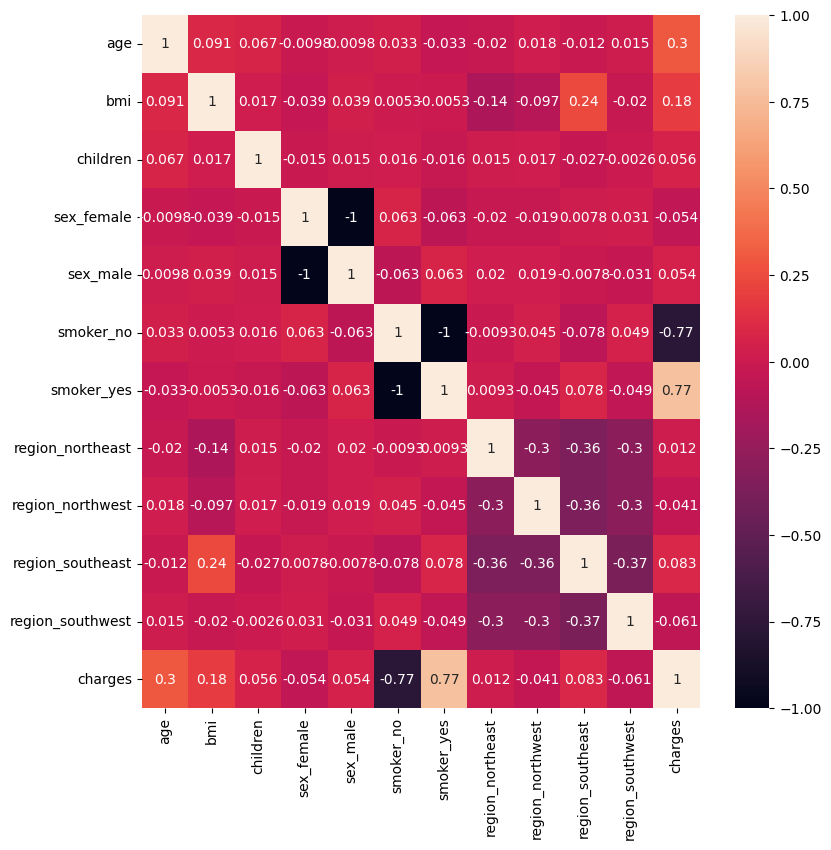

In [26]:
# using seaborn we can visualise these correlations easier via a heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9)) 
sns.heatmap(cleaned_data.corr(), annot=True)

The first thing we have noticed are the strong correlations between smoking and charges: those who smoke have much higher insurance costs since the correlation between smoker_yes and charges is 0.77. This is likely due to all the health issues that arise due to smoking. On the other hand, as seen through the correlation of -0.77, not smoking leads to lower insurance costs. Age and bmi also both have significant correlations with charges (0.3 and 0.18): as people get older or have a higher bmi (which usually means higher weight) they also suffer from many health complications which would explain this. 

Some of the insights from this visualisation are seemingly irrelevant though, as seen in the correlation between bmi and region_southeast, while this could imply that this region will have higher charges we see that while this is true, it's not much higher than the other regions.

## _Step 4: Selecting and Hypertuning/Finetuning ML Models, and Performance Analysis_ ##

**In this section we have experimented with tuning different hyperparameters of an artificial neural network model. We repeated the model definition, compiling, and fitting with changing the numbers of neurons on each layer, the number of hidden layers, the dropout percentage, the optimizer, and epochs. We then selected the model that yielded the lowest MAE. Below are a few of the models we developed.**

In [225]:
print(X_train_transformed.shape)  # Check the shape
print(X_test_transformed.shape)   # Ensure consistency between train and test


(909, 11)
(228, 11)


**1: Model 1**

In [232]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the regression model
model1 = Sequential([
    Dense(16, activation='relu', input_shape=(11,)),  # Input layer
    Dropout(0.1),  # Regularization
    Dense(64, activation='relu'),  # Hidden layer 1
    Dropout(0.1),  # Regularization
    Dense(1)  # Single output for regression
])
model1.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_137 (Dense)           (None, 16)                192       
                                                                 
 dropout_105 (Dropout)       (None, 16)                0         
                                                                 
 dense_138 (Dense)           (None, 64)                1088      
                                                                 
 dropout_106 (Dropout)       (None, 64)                0         
                                                                 
 dense_139 (Dense)           (None, 1)                 65        
                                                                 
Total params: 1345 (5.25 KB)
Trainable params: 1345 (5.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [233]:
# Compile the model
model1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [234]:
# Train the model
history1 = model1.fit(
    X_train_transformed, y_train,
    validation_data=(X_test_transformed, y_test),
    epochs=500
)

Epoch 1/500
29/29 [==============================] - 0s 4ms/step - loss: 322428640.0000 - mean_absolute_error: 13322.5566 - val_loss: 320327040.0000 - val_mean_absolute_error: 13132.9482
Epoch 2/500
29/29 [==============================] - 0s 3ms/step - loss: 322384576.0000 - mean_absolute_error: 13321.0068 - val_loss: 320265696.0000 - val_mean_absolute_error: 13130.7656
Epoch 3/500
29/29 [==============================] - 0s 2ms/step - loss: 322289056.0000 - mean_absolute_error: 13317.6689 - val_loss: 320123136.0000 - val_mean_absolute_error: 13125.7227
Epoch 4/500
29/29 [==============================] - 0s 2ms/step - loss: 322070912.0000 - mean_absolute_error: 13310.1904 - val_loss: 319822528.0000 - val_mean_absolute_error: 13114.8789
Epoch 5/500
29/29 [==============================] - 0s 3ms/step - loss: 321642112.0000 - mean_absolute_error: 13295.0605 - val_loss: 319260320.0000 - val_mean_absolute_error: 13094.2939
Epoch 6/500
29/29 [==============================] - 0s 3ms/step 

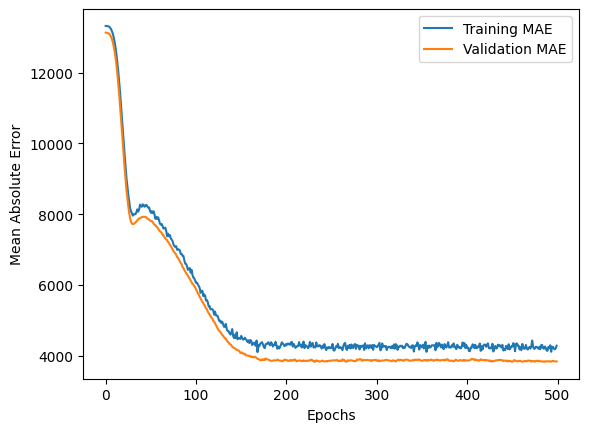

In [236]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history1.history['mean_absolute_error'], label='Training MAE')
plt.plot(history1.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [238]:
loss, mae = model1.evaluate(X_test_transformed, y_test)
print(f"Test Mean Absolute Error: {mae:.2f}")

8/8 [==============================] - 0s 2ms/step - loss: 32733176.0000 - mean_absolute_error: 3836.7329
Test Mean Absolute Error: 3836.73


The number of epochs we could stop at (train MAE stops decreasing) is around 200. While this MAE (3836.73) is not bad considering the standard deviation of the charges in our dataset is around 12k, we can try to reduce this error further by introducing another hidden layer, and changing the number of neurons.

**2: Model 2**

In [239]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the regression model
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(11,)),  # Input layer
    Dropout(0.1),  # Regularization
    Dense(64, activation='relu'),  # Hidden layer 1
    Dropout(0.1),  # Regularization
    Dense(32, activation='relu'),  # Hidden layer 2
    Dropout(0.1),  # Regularization
    Dense(1)  # Single output for regression
])
model2.summary()


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 64)                768       
                                                                 
 dropout_107 (Dropout)       (None, 64)                0         
                                                                 
 dense_141 (Dense)           (None, 64)                4160      
                                                                 
 dropout_108 (Dropout)       (None, 64)                0         
                                                                 
 dense_142 (Dense)           (None, 32)                2080      
                                                                 
 dropout_109 (Dropout)       (None, 32)                0         
                                                                 
 dense_143 (Dense)           (None, 1)               

In [240]:
# Compile the model
model2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [241]:
# Train the model
history2 = model2.fit(
    X_train_transformed, y_train,
    validation_data=(X_test_transformed, y_test),
    epochs=500
)

Epoch 1/500
29/29 [==============================] - 1s 5ms/step - loss: 322386368.0000 - mean_absolute_error: 13320.8896 - val_loss: 320209856.0000 - val_mean_absolute_error: 13128.3418
Epoch 2/500
29/29 [==============================] - 0s 2ms/step - loss: 322020416.0000 - mean_absolute_error: 13307.0508 - val_loss: 319408320.0000 - val_mean_absolute_error: 13098.0645
Epoch 3/500
29/29 [==============================] - 0s 2ms/step - loss: 320148864.0000 - mean_absolute_error: 13238.4844 - val_loss: 315820000.0000 - val_mean_absolute_error: 12963.2061
Epoch 4/500
29/29 [==============================] - 0s 2ms/step - loss: 313395712.0000 - mean_absolute_error: 12982.6025 - val_loss: 304429952.0000 - val_mean_absolute_error: 12526.5596
Epoch 5/500
29/29 [==============================] - 0s 3ms/step - loss: 295027008.0000 - mean_absolute_error: 12284.1016 - val_loss: 278052960.0000 - val_mean_absolute_error: 11461.1592
Epoch 6/500
29/29 [==============================] - 0s 2ms/step 

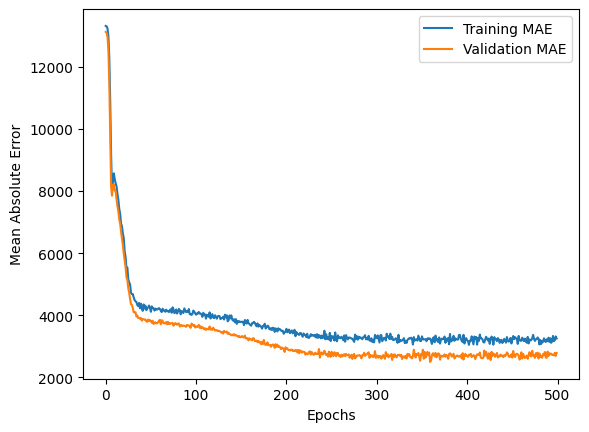

In [242]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history2.history['mean_absolute_error'], label='Training MAE')
plt.plot(history2.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [244]:
loss, mae = model2.evaluate(X_test_transformed, y_test)
print(f"Test Mean Absolute Error: {mae:.2f}")

8/8 [==============================] - 0s 1ms/step - loss: 18430376.0000 - mean_absolute_error: 2785.7024
Test Mean Absolute Error: 2785.70


This time the optimal number of epochs is around 250-300. The MAE has decreased to 2785.7, but there still may be room for improvement. We can add another hidden layer, tune the number of neurons further, and try using 'rmsprop' instead of 'adam' as our optimizer.

**3: Model 3**

In [459]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the regression model
model3 = Sequential([
    Dense(100, activation='relu', input_shape=(11,)),  # Input layer
    Dropout(0.1),  # Regularization
    Dense(128, activation='relu'),  # Hidden layer 1
    Dropout(0.1),  # Regularization
    Dense(64, activation='relu'),  # Hidden layer 2
    Dropout(0.1),  # Regularization
    Dense(32, activation='relu'),  # Hidden layer 3
    Dropout(0.1),  # Regularization
    Dense(1)  # Single output for regression
])
model3.summary()

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_326 (Dense)           (None, 100)               1200      
                                                                 
 dropout_256 (Dropout)       (None, 100)               0         
                                                                 
 dense_327 (Dense)           (None, 128)               12928     
                                                                 
 dropout_257 (Dropout)       (None, 128)               0         
                                                                 
 dense_328 (Dense)           (None, 64)                8256      
                                                                 
 dropout_258 (Dropout)       (None, 64)                0         
                                                                 
 dense_329 (Dense)           (None, 32)              

In [460]:
# Compile the model
model3.compile(
    optimizer='rmsprop',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [461]:
# Train the model
history3 = model3.fit(
    X_train_transformed, y_train,
    validation_data=(X_test_transformed, y_test),
    epochs=500
)

Epoch 1/500
29/29 [==============================] - 1s 6ms/step - loss: 322109504.0000 - mean_absolute_error: 13310.8281 - val_loss: 318997280.0000 - val_mean_absolute_error: 13081.6143
Epoch 2/500
29/29 [==============================] - 0s 3ms/step - loss: 317104800.0000 - mean_absolute_error: 13118.4258 - val_loss: 307510432.0000 - val_mean_absolute_error: 12636.6416
Epoch 3/500
29/29 [==============================] - 0s 3ms/step - loss: 293994464.0000 - mean_absolute_error: 12212.2559 - val_loss: 269453376.0000 - val_mean_absolute_error: 11070.2207
Epoch 4/500
29/29 [==============================] - 0s 3ms/step - loss: 239702208.0000 - mean_absolute_error: 10129.6602 - val_loss: 202761200.0000 - val_mean_absolute_error: 8703.6826
Epoch 5/500
29/29 [==============================] - 0s 2ms/step - loss: 175625392.0000 - mean_absolute_error: 8378.0459 - val_loss: 147667392.0000 - val_mean_absolute_error: 7891.4014
Epoch 6/500
29/29 [==============================] - 0s 3ms/step - l

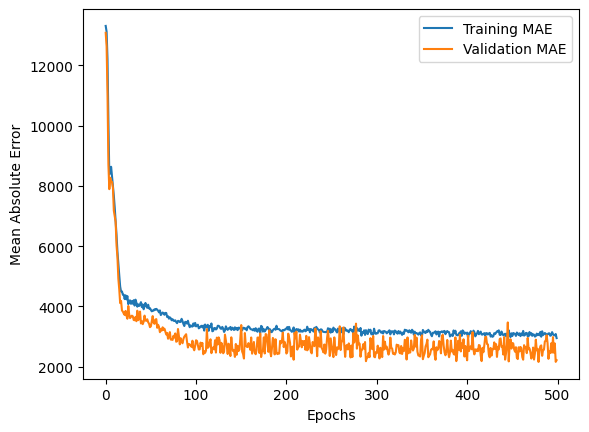

In [462]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history3.history['mean_absolute_error'], label='Training MAE')
plt.plot(history3.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [463]:
loss, mae = model3.evaluate(X_test_transformed, y_test)
print(f"Test Mean Absolute Error: {mae:.2f}")

8/8 [==============================] - 0s 5ms/step - loss: 18225532.0000 - mean_absolute_error: 2213.7317
Test Mean Absolute Error: 2213.73


While Model 3 has the lowest MAE so far, we need to put this MAE into perspective using the graph above. The graphs helps us visualise just how early the model plateaued (around 100 epochs). We can see that it was just varying slightly for the next 400 epochs, which could have led to overfitting. In our next models, we will try to cut down on training time by decreasing epochs, as well as expirmenting with more hyperparameters (batch size, learning rate,..)

**5: Model 5 (chosen)**

In [92]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the regression model
model5 = Sequential([
    Dense(100, activation='relu', input_shape=(11,)),  # Input layer
    Dropout(0.1),  # Regularization
    Dense(128, activation='relu'),  # Hidden layer 1
    Dropout(0.1),  # Regularization
    Dense(64, activation='relu'),  # Hidden layer 2
    Dropout(0.1),  # Regularization
    Dense(32, activation='relu'),  # Hidden layer 3
    Dropout(0.1),  # Regularization
    Dense(1)  # Single output for regression
])
model5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 100)               1200      
                                                                 
 dropout_44 (Dropout)        (None, 100)               0         
                                                                 
 dense_56 (Dense)            (None, 128)               12928     
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
                                                                 
 dense_57 (Dense)            (None, 64)                8256      
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                                                                 
 dense_58 (Dense)            (None, 32)              

In [93]:
# Compile the model
from tensorflow.keras.optimizers import RMSprop
optimizer=RMSprop(learning_rate=0.0005)
model5.compile(
    optimizer = optimizer,
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [94]:
# Train the model

history5 = model5.fit(
    X_train_transformed, y_train,
    validation_data=(X_test_transformed, y_test),
    epochs=150,  
    batch_size=16
)

Epoch 1/150
57/57 [==============================] - 2s 12ms/step - loss: 322254176.0000 - mean_absolute_error: 13315.8848 - val_loss: 319703392.0000 - val_mean_absolute_error: 13108.0469
Epoch 2/150
57/57 [==============================] - 0s 6ms/step - loss: 319867840.0000 - mean_absolute_error: 13224.3447 - val_loss: 314405408.0000 - val_mean_absolute_error: 12900.3770
Epoch 3/150
57/57 [==============================] - 0s 6ms/step - loss: 308800320.0000 - mean_absolute_error: 12775.5156 - val_loss: 295313760.0000 - val_mean_absolute_error: 12132.6152
Epoch 4/150
57/57 [==============================] - 0s 6ms/step - loss: 276965088.0000 - mean_absolute_error: 11517.4170 - val_loss: 250185920.0000 - val_mean_absolute_error: 10307.8164
Epoch 5/150
57/57 [==============================] - 0s 6ms/step - loss: 220586320.0000 - mean_absolute_error: 9452.6074 - val_loss: 187310896.0000 - val_mean_absolute_error: 8325.1836
Epoch 6/150
57/57 [==============================] - 0s 6ms/step -

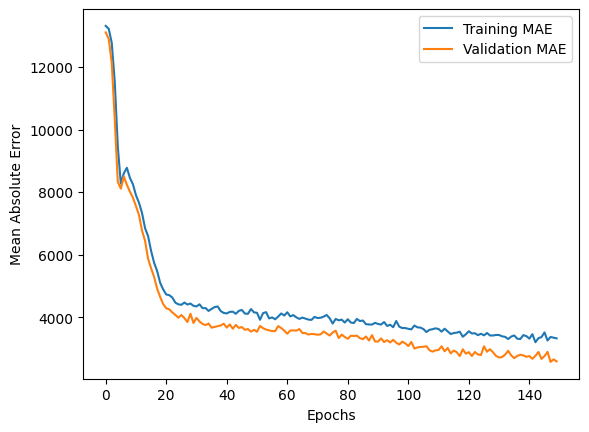

In [95]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history5.history['mean_absolute_error'], label='Training MAE')
plt.plot(history5.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [96]:
loss, mae = model5.evaluate(X_test_transformed, y_test)
print(f"Test Mean Absolute Error: {mae:.2f}")

8/8 [==============================] - 0s 2ms/step - loss: 18703798.0000 - mean_absolute_error: 2585.6787
Test Mean Absolute Error: 2585.68


Model 5 has an MAE of 2585.68, which is very close to the MAE of Model 3 (it's a good MAE for the same reasons we mentioned for Model 3). However, this model stands out because we have cut down on the training time to try and prevent overfitting (only 150 epochs). Also unlike Model 3, this model has a learning rate of 0.0005, and has a specified batch size of 16. We have experimented with other similar models (with different learning rates, batch sizes, and optimizers), but ultimately, this one performed the best and seems the most robust. Therefore, we have chosen this model and will proceed with it by inspecting its predictions via a scatter graph & absolute error.

8/8 [==============================] - 0s 4ms/step


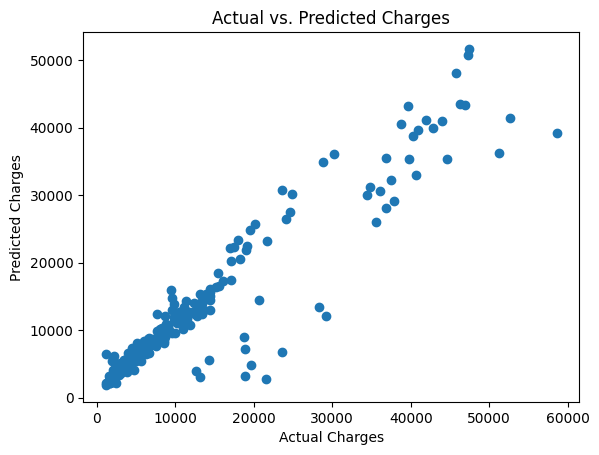

In [97]:
# Predict on validation data
y_pred = model5.predict(X_test_transformed)

# Scatter plot of actual vs. predicted charges
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges')
plt.show()


While the model seems to have better predictions for lower charges, this makes sense and is expected considering there are far less data points for the high charges which gave the model less oppurtunity to learn about them. Despite this, the graph being relatively linear all the way to the higher charges shows that the model is still good, with reasonable absolute errors as seen below.

In [98]:
for actual, pred in zip(y_test, y_pred):
    print('Actual Charges: ', actual, ' Predicted charges: ', pred, ' abs_error: ', abs(pred - actual))


Actual Charges:  7526.70645  Predicted charges:  [7692.514]  abs_error:  [165.80762]
Actual Charges:  17179.522  Predicted charges:  [17404.992]  abs_error:  [225.4707]
Actual Charges:  2219.4451  Predicted charges:  [4019.5637]  abs_error:  [1800.1187]
Actual Charges:  8733.22925  Predicted charges:  [12037.817]  abs_error:  [3304.588]
Actual Charges:  5976.8311  Predicted charges:  [6794.242]  abs_error:  [817.41113]
Actual Charges:  7518.02535  Predicted charges:  [8405.524]  abs_error:  [887.499]
Actual Charges:  40273.6455  Predicted charges:  [38680.52]  abs_error:  [1593.125]
Actual Charges:  12224.35085  Predicted charges:  [12606.536]  abs_error:  [382.18555]
Actual Charges:  40932.4295  Predicted charges:  [39606.375]  abs_error:  [1326.0547]
Actual Charges:  2566.4707  Predicted charges:  [3575.103]  abs_error:  [1008.6323]
Actual Charges:  11082.5772  Predicted charges:  [11507.597]  abs_error:  [425.01953]
Actual Charges:  41949.2441  Predicted charges:  [41142.453]  abs_e

## _Step 5: Saving/Importing Chosen Model_ ##

In [99]:
# saving the model we chose: model 5

model5.save('trained_model.keras')   

In [469]:
import pickle

# saving the preprocessing functions (scaler, imputer, and one hot encoder) onto a 'scaler.pkl' file.

with open('imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(one_hot_encoder, f)

with open('imp_neg_mode.pkl', 'wb') as f:
    pickle.dump(imp_neg_mode, f)

with open('imp_region_mode.pkl', 'wb') as f:
    pickle.dump(imp_region_mode, f)

with open('imp_typos_mode.pkl', 'wb') as f:
    pickle.dump(imp_typos_mode, f)
